In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# sys.path.append('../src')
# import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### Modelling

In [ ]:
from fastai.text.all import *

In [ ]:
path = Path('../..')

In [ ]:
files = get_text_files(path, folders = ['just_icds'])

In [ ]:
len(files)

79174

In [10]:
txt = files[10].open().read(); txt[:75]

'xxbos e881 z23 e785 r5381 g620 q828 f410 ttlc_60 z1331 r000 ttlc_15 j441 r9'

In [13]:
txts = L(o.open().read().split(' ') for o in files)

In [14]:
len(txts)

79174

In [80]:
lens = [len(t) for t in txts]

In [82]:
np.mean(lens), np.max(lens), np.min(lens)

(445.10812893121476, 14228, 1)

In [15]:
num = Numericalize(min_freq=20)
num.setup(txts)

In [16]:
coll_repr(num.vocab, 20)

"(#14008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','ttlc_1','i10','ttlc_5','ttlc_10','ttlc_2','e119','n186','j449','ttlc_30','m6281','z992'...]"

In [17]:
nums = txts.map(num)

In [ ]:
' '.join(num.vocab[o] for o in nums[0])

In [109]:
dl = LMDataLoader(nums)

In [110]:
x,y = first(dl)

In [112]:
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [113]:
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos ttlc_0 i1311 n185 z905 r630 r634 d631 ttlc_0 i1311 n185 z905 r630 r634 d631 ttlc_0 i1311 n185 z905 r630'

In [114]:
' '.join(num.vocab[o] for o in y[0][:20])

'ttlc_0 i1311 n185 z905 r630 r634 d631 ttlc_0 i1311 n185 z905 r630 r634 d631 ttlc_0 i1311 n185 z905 r630 r634'

In [120]:
dl?

Type:        LMDataLoader
String form: <fastai.text.data.LMDataLoader object at 0x1583917c0>
Length:      463
File:        ~/.local/share/virtualenvs/data-analytics-1yVNxZKx/lib/python3.8/site-packages/fastai/text/data.py
Docstring:   A `DataLoader` suitable for language modeling


In [20]:
dls = TextDataLoaders.from_folder(
    path / 'just_icds', valid_pct=.1,
    seed=None,
    text_vocab=num.vocab,
    is_lm=True,
    tok_tfm=None,
    seq_len=72,
    backwards=False,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None
)

In [21]:
learn = language_model_learner(
    dls=dls,
    arch=AWD_LSTM,
    drop_mult=1,
    pretrained=False,
    metrics=[accuracy, Perplexity()]).to_fp16()

/home/bp/.local/share/virtualenvs/data-analytics-qWXImv-u/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0002290867705596611)

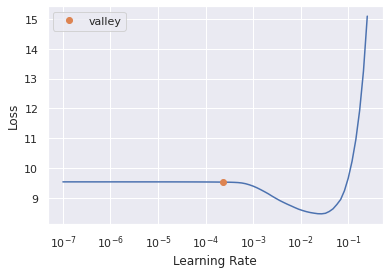

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.963367,4.985633,0.188913,146.296143,22:36


In [26]:
learn.fit_one_cycle(20, 2e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.878683,4.882506,0.199884,131.960938,22:50
1,4.484203,4.615439,0.228636,101.032166,22:38
2,3.830352,4.015234,0.322365,55.436264,22:33
3,3.487774,3.535611,0.396861,34.315971,22:36
4,3.211609,3.292233,0.427635,26.902870,22:37
5,3.179427,3.152504,0.443818,23.394581,22:32
6,3.101207,3.068931,0.452708,21.518885,22:34
7,3.015949,3.006184,0.461579,20.210133,22:52
8,3.123395,2.957121,0.467365,19.242495,22:49
9,3.013978,2.925106,0.471856,18.636208,22:33


In [27]:
models_path = '/home/bp/data-analytics/models'
file = models_path + 'lml_epoch_20_20220918.pkl'
file

'/home/bp/data-analytics/modelslml_epoch_20_20220918.pkl'

In [28]:
learn.save(file, with_opt=True, pickle_protocol=2)

Path('/home/bp/data-analytics/modelslml_epoch_20_20220918.pkl.pth')

In [83]:
file = models_path + 'lml_epoch_20_encoder_20220918'
learn.save_encoder(file)

In [87]:
file

'/home/bp/data-analytics/modelslml_epoch_20_encoder_20220918'

In [86]:
vocab_path = models_path + 'lml_epoch_20_vocab_20220918.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(num.vocab, f)
vocab_path

'/home/bp/data-analytics/modelslml_epoch_20_vocab_20220918.pkl'

### Visualize Results

In [29]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(14008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(14008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=14008, bias=True)
    (output_dp): RNNDropout()
  )
)

In [75]:
from torch.nn import functional as F

def get_normalized_embeddings():
    return F.normalize(learn.model[0].encoder.weight)

def most_similar(token, embs):
    if token[:2] == 'xx':
        return
#     idx = num.vocab.itos.index(token)
    idx = num.vocab.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}: {icd_lookup[token]}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        if num.vocab[sim_idx][:2] == 'xx':
            print(f'{sims[sim_idx]:.02f}: {num.vocab[sim_idx]}')
        else:
            print(f'{sims[sim_idx]:.02f}: {num.vocab[sim_idx]}: {icd_lookup[num.vocab[sim_idx]]}')
            

In [76]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
import json


with open('icd_descr_lookup.json', 'r') as f:
    icd_lookup = json.load(f)

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [77]:
embeddings = get_normalized_embeddings()
most_similar('e11', embeddings)

Similar to: e11: Type 2 diabetes mellitus
0.87: r73: Elevated blood glucose level
0.86: m79: Other and unspecified soft tissue disorders, not elsewhere classified
0.86: e10: Type 1 diabetes mellitus
0.86: e78: Disorders of lipoprotein metabolism and other lipidemias
0.86: e08: Diabetes mellitus due to underlying condition
0.85: d64: Other anemias
0.85: m54: Dorsalgia
0.85: m25: Other joint disorder, not elsewhere classified
0.85: r60: Edema, not elsewhere classified
0.85: z00: Encounter for general examination without complaint, suspected or reported diagnosis


In [78]:
for code in random.sample(num.vocab, 10):
    most_similar(code, embeddings)
    print('')

Similar to: m8588: Other specified disorders of bone density and structure, other site
0.95: m85851: Other specified disorders of bone density and structure, right thigh
0.95: m85852: Other specified disorders of bone density and structure, left thigh
0.94: m8589: Other specified disorders of bone density and structure, multiple sites
0.93: z780: Asymptomatic menopausal state
0.93: z13820: Encounter for screening for osteoporosis
0.92: e2839: Other primary ovarian failure
0.91: m85859: Other specified disorders of bone density and structure, unspecified thigh
0.91: n958: Other specified menopausal and perimenopausal disorders
0.90: r920: Mammographic microcalcification found on diagnostic imaging of breast
0.90: n6011: Diffuse cystic mastopathy of right breast

Similar to: q203: Discordant ventriculoarterial connection
0.94: q2542: Hypoplasia of aorta
0.94: q204: Double inlet ventricle
0.94: q200: Common arterial trunk
0.94: p7889: Other specified perinatal digestive system disorders
0

In [74]:
'xxfake'[:2]

'xx'

In [47]:
icd_lookup = icd_lookup[0]['jsonb_object_agg']

In [48]:
icd_lookup['e11']

'Type 2 diabetes mellitus'

In [49]:
with open('icd_descr_lookup.json', 'w') as f:
    json.dump(icd_lookup, f)